In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='/content/sample_data',train=True,download=True,
                            transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 125572993.42it/s]


Extracting /content/sample_data/MNIST/raw/train-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35913339.41it/s]

Extracting /content/sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39531351.76it/s]

Extracting /content/sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/sample_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3979638.35it/s]


Extracting /content/sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/sample_data/MNIST/raw



In [5]:
test_data = datasets.MNIST(root='/content/sample_data',train=False,download=True,
                            transform=transform)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/sample_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image,label = train_data[0]

In [8]:
image.shape

torch.Size([1, 28, 28])

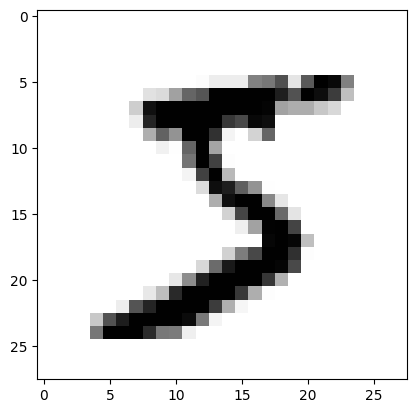

In [9]:
plt.imshow(image.reshape(28,28),cmap='gist_yarg')

In [10]:
torch.manual_seed(101)


tran_loader = DataLoader(train_data,batch_size=100,shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [11]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [12]:
for images,labels in tran_loader:
  break

In [13]:
images.shape

torch.Size([100, 1, 28, 28])

In [14]:
labels.shape

torch.Size([100])

Labels:  [   7    1    6    9    5    0    7    1    1    9    5    7]


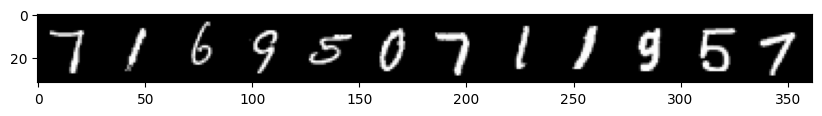

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in tran_loader:
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [16]:
class MultilayerPerceptron(nn.Module):

  def __init__(self,in_sz = 784, out_sz=10,layers=[120,84]):
    super().__init__()

    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)

  def forward(self,X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X,dim=1)


In [17]:
torch.manual_seed(101)

model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
for param in model.parameters():
  print(param.numel())

94080
120
10080
84
840
10


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [20]:
#flatten out images [100,784]
images.view(100,-1).shape

torch.Size([100, 784])

In [21]:
#training the model

import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):

  trn_corr = 0
  tst_corr = 0

  for b, (X_train,y_train) in enumerate(tran_loader):

    b+=1

    y_pred = model(X_train.view(100,-1))
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()

    trn_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%200 ==0:
      acc = trn_corr.item()*100/(100*b)
      print(f'Epoch {i} batch {b} loss:{loss.item()} accuracy: {acc}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  with torch.no_grad():

    for b, (X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test.view(500,-1))

      predicted = torch.max(y_val.data,1)[1]

      tst_corr += (predicted==y_test).sum()


  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)




total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')

Epoch 0 batch 200 loss:0.23541299998760223 accuracy: 83.25
Epoch 0 batch 400 loss:0.35372811555862427 accuracy: 87.5275
Epoch 0 batch 600 loss:0.13645224273204803 accuracy: 89.57333333333334
Epoch 1 batch 200 loss:0.24461665749549866 accuracy: 94.835
Epoch 1 batch 400 loss:0.14581231772899628 accuracy: 95.0525
Epoch 1 batch 600 loss:0.0729987770318985 accuracy: 95.35
Epoch 2 batch 200 loss:0.08550902456045151 accuracy: 96.545
Epoch 2 batch 400 loss:0.060599278658628464 accuracy: 96.6275
Epoch 2 batch 600 loss:0.06172013655304909 accuracy: 96.68666666666667
Epoch 3 batch 200 loss:0.11930723488330841 accuracy: 97.62
Epoch 3 batch 400 loss:0.060178760439157486 accuracy: 97.4625
Epoch 3 batch 600 loss:0.03130100667476654 accuracy: 97.47166666666666
Epoch 4 batch 200 loss:0.12001627683639526 accuracy: 98.115
Epoch 4 batch 400 loss:0.04872922599315643 accuracy: 97.9925
Epoch 4 batch 600 loss:0.05167201906442642 accuracy: 98.01333333333334
Epoch 5 batch 200 loss:0.00876355729997158 accuracy: 